<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 9 - Multilayer Perceptron Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[MLP with Simple Features](#mlp-simple)  
[MLP with Full Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the multilayer perceptron classifier to the Indonesia dataset and explore how having an unbalanced dataset impacts the classifier performance. 

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import IDN_BASIC_FEATURES

ALGORITHM_NAME = 'mlp'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# MLP with simple features <a class="anchor" id="mlp-simple"></a>

We'll start with the simple set of features stored in `IDN_BASIC_FEATURES` in the `process_features` module.

In [3]:
# Select the basic features we've used previously
selected_columns = IDN_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 9)


CPU times: user 56.5 s, sys: 11min 30s, total: 12min 26s
Wall time: 1min 26s
CPU times: user 156 ms, sys: 1.41 s, total: 1.56 s
Wall time: 520 ms
In-sample score: 91.12%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


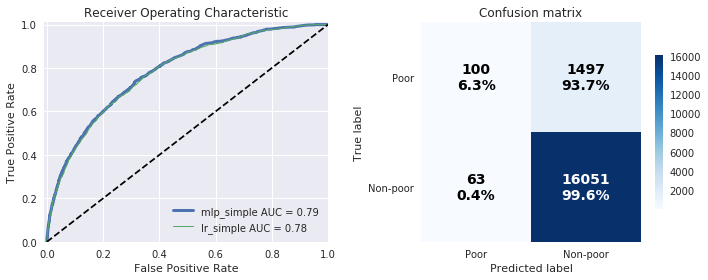

,mlp_simple,lr_simple
accuracy,0.911919,0.91158
recall,0.0626174,0.0851597
precision,0.613497,0.564315
f1,0.113636,0.147987
cross_entropy,0.254315,0.256817
roc_auc,0.786015,0.781848
cohen_kappa,0.0985809,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 0.58% 


In [4]:
from sklearn.neural_network import MLPClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = MLPClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

# MLP with all features <a class="anchor" id="all-feats"></a>

Now let's apply the MLP classifier to the dataset with all features. 

CPU times: user 7min 57s, sys: 1h 20min 23s, total: 1h 28min 20s
Wall time: 21min 1s
CPU times: user 810 ms, sys: 1.87 s, total: 2.68 s
Wall time: 1.05 s
In-sample score: 99.88%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


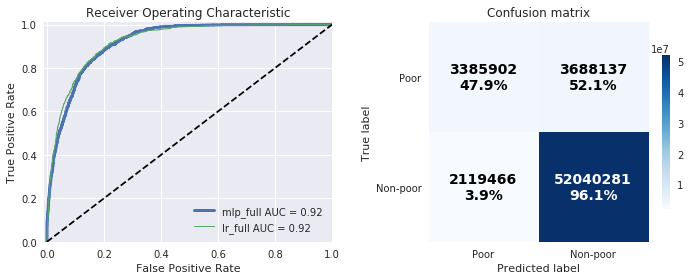

,mlp_full,lr_full
accuracy,0.905157,0.910251
recall,0.478638,0.456232
precision,0.615018,0.661838
f1,0.538325,0.540131
cross_entropy,0.546706,0.212947
roc_auc,0.919996,0.923198
cohen_kappa,0.520722,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 10.65% 


In [5]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = MLPClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Undersampling <a class="anchor" id="undersampling">
Now we'll apply undersampling and see how the performance is affected.

X shape after undersampling:  (9584, 453)
CPU times: user 2min 23s, sys: 25min 20s, total: 27min 43s
Wall time: 2min 16s
CPU times: user 292 ms, sys: 1.95 s, total: 2.24 s
Wall time: 386 ms
In-sample score: 100.00%
CPU times: user 324 ms, sys: 1.28 s, total: 1.61 s
Wall time: 410 ms
CPU times: user 422 ms, sys: 1.78 s, total: 2.2 s
Wall time: 405 ms


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


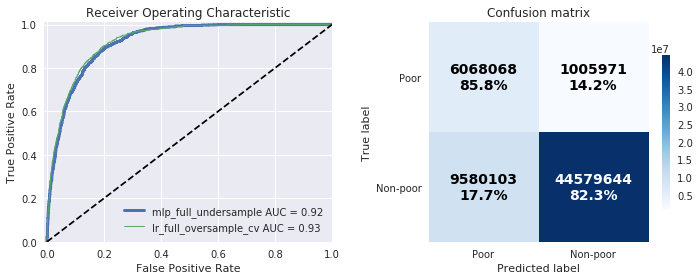

,mlp_full_undersample,lr_full_oversample_cv
accuracy,0.82712,0.851611
recall,0.857794,0.838116
precision,0.387781,0.427456
f1,0.534109,0.566159
cross_entropy,0.831168,0.348544
roc_auc,0.919972,0.925356
cohen_kappa,0.441922,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 25.03% 


In [6]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = MLPClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Oversampling <a class="anchor" id="oversampling">

X shape after oversampling:  (96680, 453)
CPU times: user 9min 3s, sys: 1h 29min 51s, total: 1h 38min 55s
Wall time: 7min 30s
CPU times: user 1.18 s, sys: 1.86 s, total: 3.03 s
Wall time: 1.42 s
In-sample score: 99.75%
CPU times: user 310 ms, sys: 1.1 s, total: 1.41 s
Wall time: 499 ms
CPU times: user 302 ms, sys: 1.28 s, total: 1.58 s
Wall time: 547 ms


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


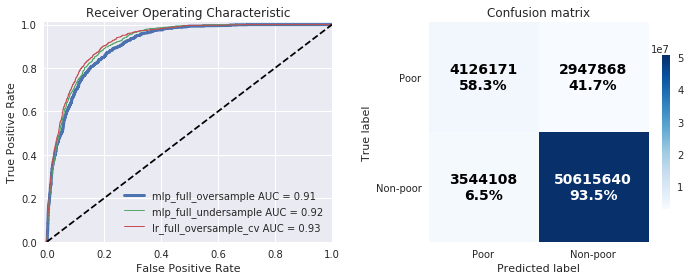

,mlp_full_oversample,mlp_full_undersample,lr_full_oversample_cv
accuracy,0.89398,0.82712,0.851611
recall,0.583284,0.857794,0.838116
precision,0.537943,0.387781,0.427456
f1,0.559696,0.534109,0.566159
cross_entropy,0.659443,0.831168,0.348544
roc_auc,0.909939,0.919972,0.925356
cohen_kappa,0.523095,0.441922,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 11.92% 


In [7]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = MLPClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['mlp_full_undersample', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>


X shape after undersampling:  (9584, 453)
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] alpha=1.0, hidden_layer_sizes=(512,) ............................
[CV]  alpha=1.0, hidden_layer_sizes=(512,), score=0.8585732165206508, total=  46.0s
[CV] alpha=1.0, hidden_layer_sizes=(512,) ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.2s remaining:    0.0s


[CV]  alpha=1.0, hidden_layer_sizes=(512,), score=0.8519098309329993, total= 1.3min
[CV] alpha=1.0, hidden_layer_sizes=(512,) ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV]  alpha=1.0, hidden_layer_sizes=(512,), score=0.8744520976831559, total= 1.4min
[CV] alpha=1.0, hidden_layer_sizes=(1024,) ...........................
[CV]  alpha=1.0, hidden_layer_sizes=(1024,), score=0.8548185231539425, total=  55.4s
[CV] alpha=1.0, hidden_layer_sizes=(1024,) ...........................
[CV]  alpha=1.0, hidden_layer_sizes=(1024,), score=0.84815278647464, total= 1.3min
[CV] alpha=1.0, hidden_layer_sizes=(1024,) ...........................
[CV]  alpha=1.0, hidden_layer_sizes=(1024,), score=0.8606762680025047, total= 1.2min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.9min finished


CPU times: user 12min 24s, sys: 1h 43min 17s, total: 1h 55min 41s
Wall time: 7min 48s
CPU times: user 792 ms, sys: 1.7 s, total: 2.49 s
Wall time: 138 ms
In-sample score: 91.75%
Best model parameters: {'alpha': 1.0, 'hidden_layer_sizes': (512,)}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


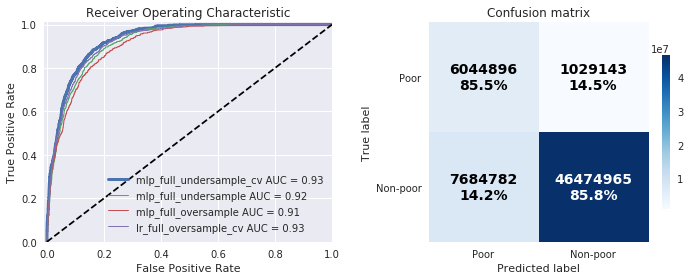

,mlp_full_undersample_cv,mlp_full_undersample,mlp_full_oversample,lr_full_oversample_cv
accuracy,0.857694,0.82712,0.89398,0.851611
recall,0.854518,0.857794,0.583284,0.838116
precision,0.44028,0.387781,0.537943,0.427456
f1,0.581136,0.534109,0.559696,0.566159
cross_entropy,0.308514,0.831168,0.659443,0.348544
roc_auc,0.932805,0.919972,0.909939,0.925356
cohen_kappa,0.481756,0.441922,0.523095,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 22.21% 


In [8]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = MLPClassifier()
parameters = {'hidden_layer_sizes': [(512,), (1024,)],
              'alpha': [1.0]
             }
model = GridSearchCV(estimator, parameters, verbose=3, cv=3)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['mlp_full_undersample',
                                                    'mlp_full_oversample',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)
best_model = model.best_estimator_

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling. 

# Multilayer Perceptron Indonesia Summary <a class="anchor" id="summary"></a>



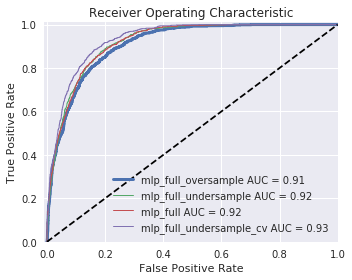

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
mlp_full_oversample,0.89398,0.583284,0.537943,0.559696,0.659443,0.909939,0.523095,0.00541482
mlp_full_undersample,0.82712,0.857794,0.387781,0.534109,0.831168,0.919972,0.441922,0.136475
mlp_full,0.905157,0.478638,0.615018,0.538325,0.546706,0.919996,0.520722,-0.0072533
mlp_full_undersample_cv,0.857694,0.854518,0.44028,0.581136,0.308514,0.932805,0.481756,0.108348


In [9]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)